Task 1


Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

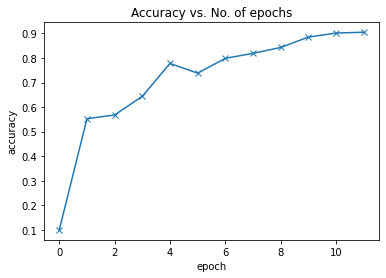

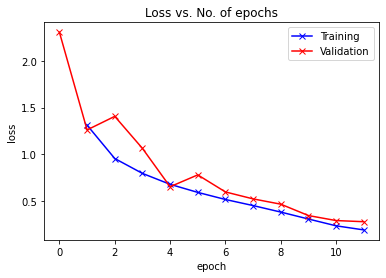

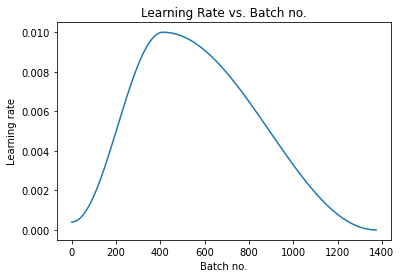

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

import warnings
warnings.filterwarnings("ignore")



class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))


class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Dropout(0.2),
            nn.Linear(256*4*4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        if epoch%2 == 0:
            path = f'/content/drive/MyDrive/VCL/T1/M1_epoch_{epoch}.pt'
            torch.save(model.state_dict(), path)
    return history
 
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)






def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig('/content/drive/MyDrive/VCL/T1/Accuracy_vs._No. of epochs.pdf',format='pdf')
    plt.show()


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.savefig('/content/drive/MyDrive/VCL/T1/Loss_vs._No. of epochs.pdf',format='pdf')
    plt.show()

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.savefig('/content/drive/MyDrive/VCL/T1/LearningRate_vs._No. of epochs.pdf',format='pdf')
    plt.show()












if __name__ == '__main__':
    # Data transforms (normalization & data augmentation)
    stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                            tt.RandomHorizontalFlip(), 
                            # tt.RandomRotate
                            # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                            # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                            tt.ToTensor(), 
                            tt.Normalize(*stats,inplace=True)])
    valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
    # PyTorch datasets
    train_ds = CIFAR10(root='data/', download=True, transform=train_tfms)
    valid_ds = CIFAR10(root='data/', train=False, transform=valid_tfms)
    dataset_size = len(train_ds)
    test_dataset_size = len(valid_ds)
    print(train_ds)
    print(valid_ds)
    batch_size = 400

    # PyTorch data loaders
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)
    device = get_default_device()
    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)

    model = to_device(Cifar10CnnModel(), device)
    print(model)
    os.environ['WANDB_CONSOLE'] = 'off'
    history = [evaluate(model, valid_dl)]
    print(history)

    epochs = 11
    max_lr = 0.01
    grad_clip = 0.1
    weight_decay = 1e-4
    opt_func = torch.optim.Adam

    os.environ['WANDB_CONSOLE'] = 'off'

    history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
    
    plot_accuracies(history)
    plot_losses(history)
    plot_lrs(history)


In [ ]:


def prune_model_global_unstructured(model, proportion, layer_type=torch.nn.Conv2d):
    module_tups = []
    for module in model.modules():
        if isinstance(module, layer_type):
            module_tups.append((module, 'weight'))

    prune.global_unstructured(
        parameters=module_tups, pruning_method=prune.L1Unstructured,
        amount=proportion
    )
    for module, _ in module_tups:
        prune.remove(module, 'weight')
    return model

In [ ]:
def measure_sparsity(model):
  num_of_zeros,num_of_parameters=0,0
  for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            num_of_zeros+= torch.sum(module.weight == 0)
            num_of_zeros+=torch.sum(module.bias == 0)
            num_of_parameters+=module.weight.nelement()
            num_of_parameters+=module.bias.nelement()
  print(f'Global Sparsity{100*float(num_of_zeros.cpu().item())/float(num_of_parameters)}%')


def iterative_pruning_finetuning(epochs, 
                                 max_lr,
                                 model, 
                                 train_dl, valid_dl,
                                 input,
                                grad_clip=None, 
                                weight_decay=0, 
                                opt_func=torch.optim.SGD,
                                 conv2d_prune_amount=0.1,
                                 linear_prune_amount=0.2,
                                 num_iterations=1,
                                 num_epochs_per_iteration=10,
                                 grouped_pruning = True):
  
    iter_history=[]
    for i in range(num_iterations):

        
        history = [evaluate(model, valid_dl)]
        print(history)
        print("Pruning and Finetuning {}/{}".format(i + 1, num_iterations))




        print("Pruning...")

        if grouped_pruning == True:
            # Global pruning
            # I would rather call it grouped pruning.
            parameters_to_prune = []
            for module_name, module in model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    parameters_to_prune.append((module, "weight"))
                    parameters_to_prune.append((module, "bias"))
                # if isinstance(module, torch.nn.Linear):
                #     parameters_to_prune.append((module, "weight"))
                #     parameters_to_prune.append((module, "bias"))
            prune.global_unstructured(
                parameters_to_prune,
                pruning_method=prune.L1Unstructured,
                amount=conv2d_prune_amount*(1+input),
            )
        else:
            for module_name, module in model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    prune.l1_unstructured(module,
                                        name="weight",
                                        amount=conv2d_prune_amount)
                elif isinstance(module, torch.nn.Linear):
                    prune.l1_unstructured(module,
                                        name="weight",
                                        amount=linear_prune_amount)

        
        # print(parameters_to_prune)
        measure_sparsity(model)
        post_pruning_history = [evaluate(model, valid_dl)]
        print(post_pruning_history)

        # print(model.conv1._forward_pre_hooks)

        print("Fine-tuning...")

        history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, input,
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
        plot_accuracies(history,input)
        plot_losses(history,input)
        plot_lrs(history,input)
        history = [evaluate(model, valid_dl)]
        print(history)
    return history , post_pruning_history


def remove_parameters(model):

    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass
        elif isinstance(module, torch.nn.Linear):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass

    return model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

import warnings
warnings.filterwarnings("ignore")
import os
import copy
import torch.nn.utils.prune as prune


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))


class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Dropout(0.2),
            nn.Linear(256*4*4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, input,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        if (epoch+1)%2==0:
            path = f'/content/drive/MyDrive/VCL/M2_{(input+1)*10}%pruned_epoch_{epoch}.pt'
            torch.save(model.state_dict(), path)
    return history
 
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)






def plot_accuracies(history,input):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig(f'/content/drive/MyDrive/VCL/Accuracy_vs._No. of epochs_{(input+1)*10}%pruned.pdf',format='pdf')
    plt.show()


def plot_losses(history,input):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.savefig(f'/content/drive/MyDrive/VCL/Loss_vs._No. of epochs_{(input+1)*10}%pruned.pdf',format='pdf')
    plt.show()

def plot_lrs(history,input):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.savefig(f'/content/drive/MyDrive/VCL/LearningRate_vs._No. of epochs_{(input+1)*10}%pruned.pdf',format='pdf')
    plt.show()

def post_finetuning_history(history,input):
    val_acc = [x.get('val_acc') for x in history]
    
    plt.plot(val_acc, '-bx')
    
    plt.xlabel('iter')
    plt.ylabel('val_acc')
    plt.legend(['Training', 'Validation'])
    plt.title('post_finetuning_accuracy')
    plt.savefig(f'/content/drive/MyDrive/VCL/post_finetuning_accuracy_{(input+1)*10}%pruned.pdf',format='pdf')
    plt.show()




Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
[{'val_loss': 2.302887201309204, 'val_acc': 0.10067307949066162}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity10.0%
[{'val_loss': 0.2834690511226654, 'val_acc': 0.9049038290977478}]
Fine-tuning...
Epoch [0], train_loss: 0.2346, val_loss: 0.4175, val_acc: 0.8655
Epoch [1], train_l

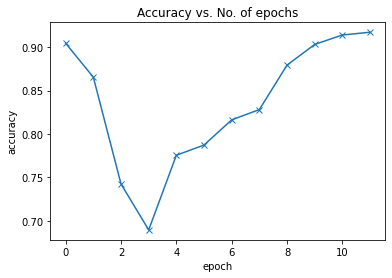

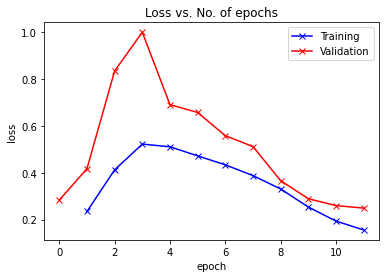

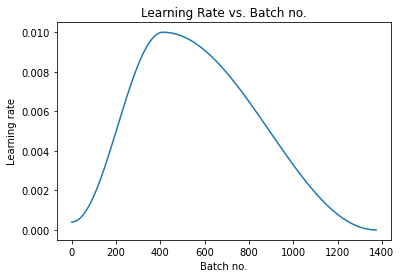

[{'val_loss': 0.24906085431575775, 'val_acc': 0.9173077940940857}]
[[{'val_loss': 0.24906085431575775, 'val_acc': 0.9173077940940857}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
[{'val_loss': 2.3029351234436035, 'val_acc': 0.08153845369815826}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity20.0%
[{'val_loss': 0.28385046124

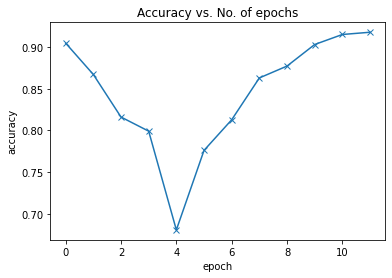

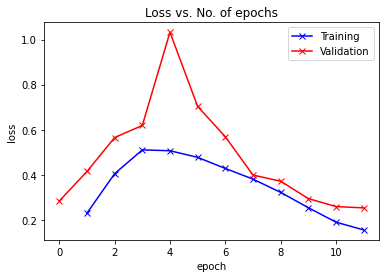

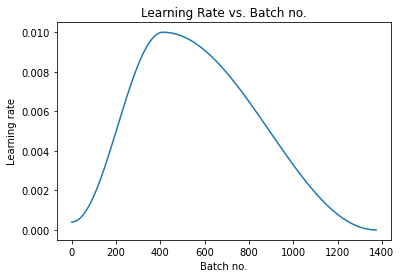

[{'val_loss': 0.25280866026878357, 'val_acc': 0.917692244052887}]
[[{'val_loss': 0.24906085431575775, 'val_acc': 0.9173077940940857}], [{'val_loss': 0.25280866026878357, 'val_acc': 0.917692244052887}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
[{'val_loss': 2.3028435707092285, 'val_acc': 0.10009615123271942}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuni

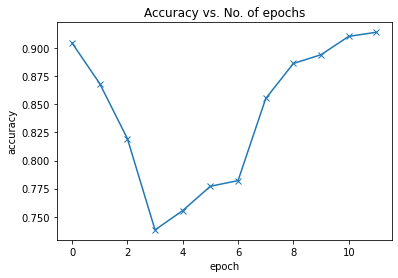

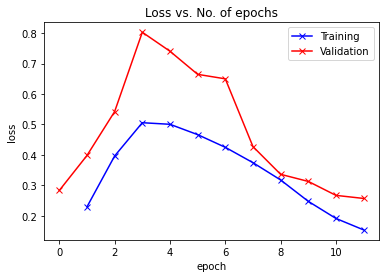

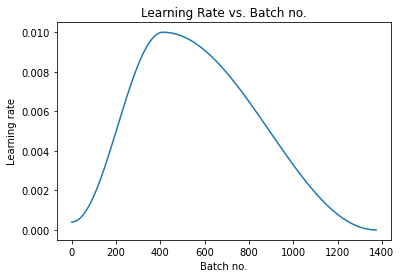

[{'val_loss': 0.25714531540870667, 'val_acc': 0.9141345620155334}]
[[{'val_loss': 0.24906085431575775, 'val_acc': 0.9173077940940857}], [{'val_loss': 0.25280866026878357, 'val_acc': 0.917692244052887}], [{'val_loss': 0.25714531540870667, 'val_acc': 0.9141345620155334}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
[{'val_loss': 2.3033463954925537, 'val_acc': 0.09913460910320282}]
[{'val_loss': 0.28

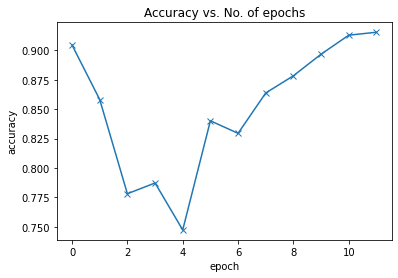

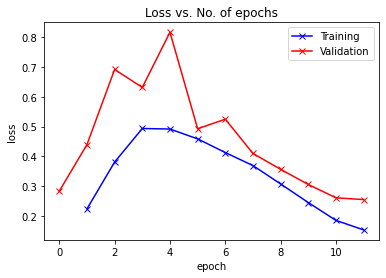

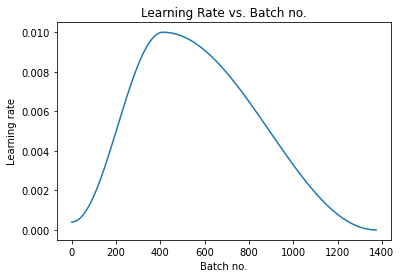

[{'val_loss': 0.25487735867500305, 'val_acc': 0.9154808521270752}]
[[{'val_loss': 0.24906085431575775, 'val_acc': 0.9173077940940857}], [{'val_loss': 0.25280866026878357, 'val_acc': 0.917692244052887}], [{'val_loss': 0.25714531540870667, 'val_acc': 0.9141345620155334}], [{'val_loss': 0.25487735867500305, 'val_acc': 0.9154808521270752}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
[{'val_loss': 2.3

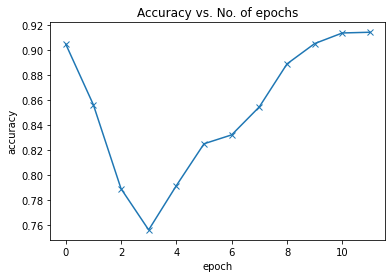

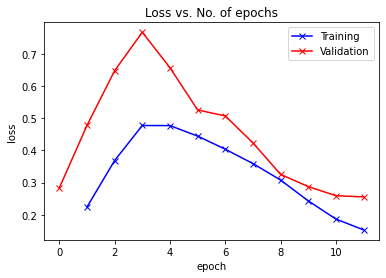

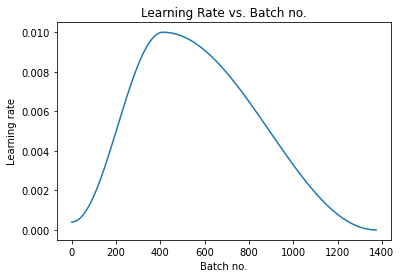

[{'val_loss': 0.2556445598602295, 'val_acc': 0.913942277431488}]
[[{'val_loss': 0.24906085431575775, 'val_acc': 0.9173077940940857}], [{'val_loss': 0.25280866026878357, 'val_acc': 0.917692244052887}], [{'val_loss': 0.25714531540870667, 'val_acc': 0.9141345620155334}], [{'val_loss': 0.25487735867500305, 'val_acc': 0.9154808521270752}], [{'val_loss': 0.2556445598602295, 'val_acc': 0.913942277431488}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.44

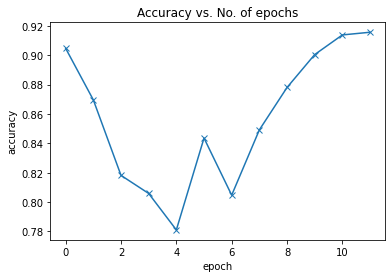

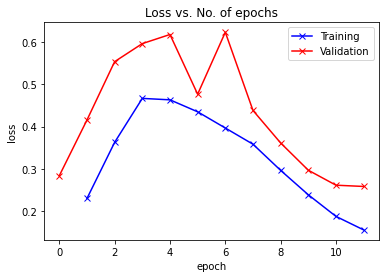

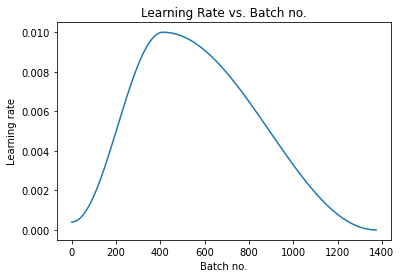

[{'val_loss': 0.25787556171417236, 'val_acc': 0.9155769348144531}]
[[{'val_loss': 0.24906085431575775, 'val_acc': 0.9173077940940857}], [{'val_loss': 0.25280866026878357, 'val_acc': 0.917692244052887}], [{'val_loss': 0.25714531540870667, 'val_acc': 0.9141345620155334}], [{'val_loss': 0.25487735867500305, 'val_acc': 0.9154808521270752}], [{'val_loss': 0.2556445598602295, 'val_acc': 0.913942277431488}], [{'val_loss': 0.25787556171417236, 'val_acc': 0.9155769348144531}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
       

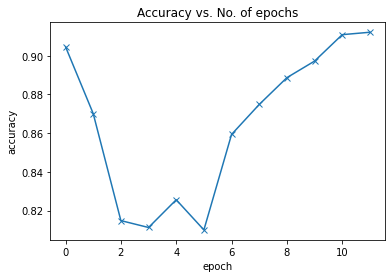

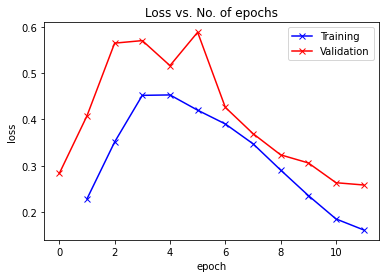

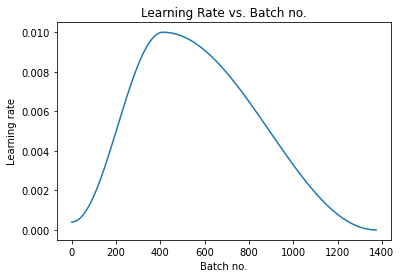

[{'val_loss': 0.258477121591568, 'val_acc': 0.9121153950691223}]
[[{'val_loss': 0.24906085431575775, 'val_acc': 0.9173077940940857}], [{'val_loss': 0.25280866026878357, 'val_acc': 0.917692244052887}], [{'val_loss': 0.25714531540870667, 'val_acc': 0.9141345620155334}], [{'val_loss': 0.25487735867500305, 'val_acc': 0.9154808521270752}], [{'val_loss': 0.2556445598602295, 'val_acc': 0.913942277431488}], [{'val_loss': 0.25787556171417236, 'val_acc': 0.9155769348144531}], [{'val_loss': 0.258477121591568, 'val_acc': 0.9121153950691223}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
 

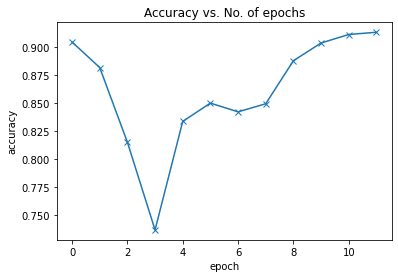

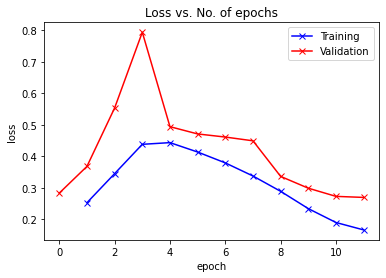

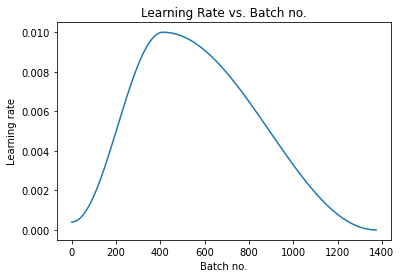

[{'val_loss': 0.269532173871994, 'val_acc': 0.9133653044700623}]
[[{'val_loss': 0.24906085431575775, 'val_acc': 0.9173077940940857}], [{'val_loss': 0.25280866026878357, 'val_acc': 0.917692244052887}], [{'val_loss': 0.25714531540870667, 'val_acc': 0.9141345620155334}], [{'val_loss': 0.25487735867500305, 'val_acc': 0.9154808521270752}], [{'val_loss': 0.2556445598602295, 'val_acc': 0.913942277431488}], [{'val_loss': 0.25787556171417236, 'val_acc': 0.9155769348144531}], [{'val_loss': 0.258477121591568, 'val_acc': 0.9121153950691223}], [{'val_loss': 0.269532173871994, 'val_acc': 0.9133653044700623}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset 

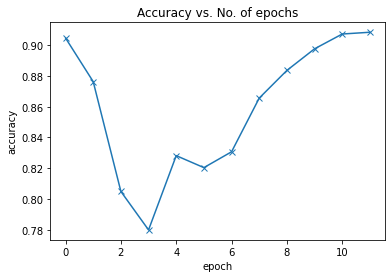

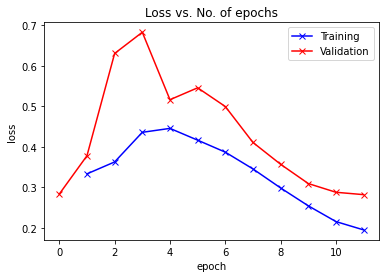

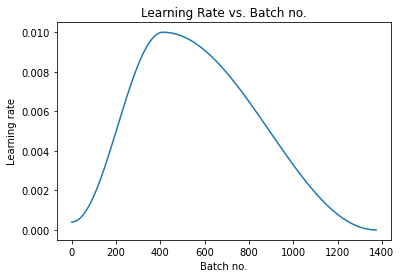

[{'val_loss': 0.2818469703197479, 'val_acc': 0.9083653092384338}]
[[{'val_loss': 0.24906085431575775, 'val_acc': 0.9173077940940857}], [{'val_loss': 0.25280866026878357, 'val_acc': 0.917692244052887}], [{'val_loss': 0.25714531540870667, 'val_acc': 0.9141345620155334}], [{'val_loss': 0.25487735867500305, 'val_acc': 0.9154808521270752}], [{'val_loss': 0.2556445598602295, 'val_acc': 0.913942277431488}], [{'val_loss': 0.25787556171417236, 'val_acc': 0.9155769348144531}], [{'val_loss': 0.258477121591568, 'val_acc': 0.9121153950691223}], [{'val_loss': 0.269532173871994, 'val_acc': 0.9133653044700623}], [{'val_loss': 0.2818469703197479, 'val_acc': 0.9083653092384338}]]


In [ ]:
if __name__ == '__main__':
    # Data transforms (normalization & data augmentation)
    percent=[]
    #iteratively pruned loaded model 
    post_finetuning_history=[]
    post_pruning_history=[]
    for i in range(9):
      stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
      train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                              tt.RandomHorizontalFlip(), 
                              # tt.RandomRotate
                              # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                              # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                              tt.ToTensor(), 
                              tt.Normalize(*stats,inplace=True)])
      valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
      # PyTorch datasets
      train_ds = CIFAR10(root='data/', download=True, transform=train_tfms)
      valid_ds = CIFAR10(root='data/', train=False, transform=valid_tfms)
      dataset_size = len(train_ds)
      test_dataset_size = len(valid_ds)
      print(train_ds)
      print(valid_ds)
      batch_size = 400

      # PyTorch data loaders
      train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
      valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)
      device = get_default_device()
      # device = torch.device('cpu')
      train_dl = DeviceDataLoader(train_dl, device)
      valid_dl = DeviceDataLoader(valid_dl, device)

      model = to_device(Cifar10CnnModel(), device)
      # print(model)
      os.environ['WANDB_CONSOLE'] = 'off'
      history = [evaluate(model, valid_dl)]
      print(history)

      epochs = 11
      max_lr = 0.01
      grad_clip = 0.1
      weight_decay = 1e-4
      opt_func = torch.optim.Adam
      
      os.environ['WANDB_CONSOLE'] = 'off'
      model = to_device(Cifar10CnnModel(), device)
      percent.append((i+1)*10)
      model.load_state_dict(torch.load('/content/drive/MyDrive/VCL/T1/M1_epoch_10.pt'))
      # model.load_state_dict(torch.load('/content/drive/MyDrive/VCL/T1/M1_epoch_10.pt',map_location=torch.device('cpu')))
      history_final , post_pruning=iterative_pruning_finetuning(epochs, max_lr, model, train_dl, valid_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func,input=i)
      post_finetuning_history.append(history_final)
      post_pruning_history.append(post_pruning)
      print(post_finetuning_history)
    
    

In [ ]:

def post_finetuning_history_plot(history):
    x_axis=[]
    for x in  history:
      for y in x:
        x_axis.append(y['val_acc'])
    
    
    plt.plot(percent,x_axis)
    plt.xlabel('%pruning')
    plt.ylabel('val_acc')
    plt.title('post_finetuning_accuracy')
    plt.savefig(f'/content/drive/MyDrive/VCL/post_finetuning_accuracy.pdf',format='pdf')
    plt.show()

In [ ]:

def post_pruning_history_plot(history):
    x_axis=[]
    for x in  history:
      for y in x:
        x_axis.append(y['val_acc'])
    
    
    plt.plot(percent,x_axis)
    plt.xlabel('%pruning')
    plt.ylabel('val_acc')
    plt.title('post_pruning_accuracy')
    plt.savefig(f'/content/drive/MyDrive/VCL/post_pruning_accuracy.pdf',format='pdf')
    plt.show()

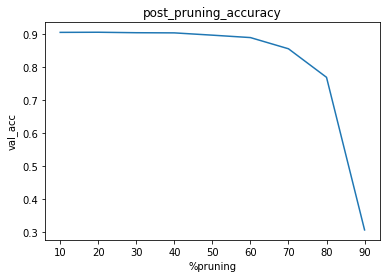

In [ ]:
post_pruning_history_plot(post_pruning_history)

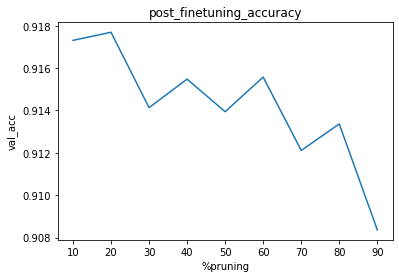

In [ ]:
post_finetuning_history_plot(post_finetuning_history)
post_pruning_history_plot(post_pruning_history)

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

import warnings
warnings.filterwarnings("ignore")
import os
import copy
import torch.nn.utils.prune as prune


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))


class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Dropout(0.2),
            nn.Linear(256*4*4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, input,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        if (epoch+1)%2==0:
            path = f'/content/drive/MyDrive/VCL/T3/M2_{(float(input)/100+.9)*100}%pruned_epoch_{epoch}.pt'
            torch.save(model.state_dict(), path)
    return history
 
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)






def plot_accuracies(history,input):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig(f'/content/drive/MyDrive/VCL/T3/Accuracy_vs._No. of epochs_{(float(input)/100+.9)*100}%pruned.pdf',format='pdf')
    plt.show()


def plot_losses(history,input):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.savefig(f'/content/drive/MyDrive/VCL/T3/Loss_vs._No. of epochs_{(float(input)/100+.9)*100}%pruned.pdf',format='pdf')
    plt.show()

def plot_lrs(history,input):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.savefig(f'/content/drive/MyDrive/VCL/T3/LearningRate_vs._No. of epochs_{(float(input)/100+.9)*100}%pruned.pdf',format='pdf')
    plt.show()

# def post_finetuning_history(history,input):
#     val_acc = [x.get('val_acc') for x in history]
    
#     plt.plot(val_acc, '-bx')
    
#     plt.xlabel('iter')
#     plt.ylabel('val_acc')
#     plt.legend(['Training', 'Validation'])
#     plt.title('post_finetuning_accuracy')
#     plt.savefig(f'/content/drive/MyDrive/VCL/T3/post_finetuning_accuracy_{(float(input)/100+.9)*100}%pruned.pdf',format='pdf')
#     plt.show()




In [ ]:
def measure_sparsity(model):
  num_of_zeros,num_of_parameters=0,0
  for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            num_of_zeros+= torch.sum(module.weight == 0)
            num_of_zeros+=torch.sum(module.bias == 0)
            num_of_parameters+=module.weight.nelement()
            num_of_parameters+=module.bias.nelement()
  print(f'Global Sparsity{100*float(num_of_zeros.cpu().item())/float(num_of_parameters)}%')


def iterative_pruning_finetuning(epochs, 
                                 max_lr,
                                 model, 
                                 train_dl, valid_dl,
                                 input,
                                grad_clip=None, 
                                weight_decay=0, 
                                opt_func=torch.optim.SGD,
                                 conv2d_prune_amount=0.9,
                                 linear_prune_amount=0.2,
                                 num_iterations=1,
                                 num_epochs_per_iteration=10,
                                 grouped_pruning = True):
  
    iter_history=[]
    for i in range(num_iterations):

        
        history = [evaluate(model, valid_dl)]
        print(history)
        print("Pruning and Finetuning {}/{}".format(i + 1, num_iterations))




        print("Pruning...")

        if grouped_pruning == True:
            # Global pruning
            # I would rather call it grouped pruning.
            parameters_to_prune = []
            for module_name, module in model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    parameters_to_prune.append((module, "weight"))
                    parameters_to_prune.append((module, "bias"))
                # if isinstance(module, torch.nn.Linear):
                #     parameters_to_prune.append((module, "weight"))
                #     parameters_to_prune.append((module, "bias"))
            prune.global_unstructured(
                parameters_to_prune,
                pruning_method=prune.L1Unstructured,
                amount=conv2d_prune_amount+(float(input)/100),
            )
        else:
            for module_name, module in model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    prune.l1_unstructured(module,
                                        name="weight",
                                        amount=conv2d_prune_amount)
                elif isinstance(module, torch.nn.Linear):
                    prune.l1_unstructured(module,
                                        name="weight",
                                        amount=linear_prune_amount)

        
        # print(parameters_to_prune)
        measure_sparsity(model)
        post_pruning_history = [evaluate(model, valid_dl)]
        print(post_pruning_history)

        # print(model.conv1._forward_pre_hooks)

        print("Fine-tuning...")

        history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, input,
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
        plot_accuracies(history,input)
        plot_losses(history,input)
        plot_lrs(history,input)
        history = [evaluate(model, valid_dl)]
        print(history)
    return history , post_pruning_history


def remove_parameters(model):

    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass
        elif isinstance(module, torch.nn.Linear):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass

    return model

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
[{'val_loss': 2.3029301166534424, 'val_acc': 0.09951923787593842}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity90.0%
[{'val_loss': 2.194772243499756, 'val_acc': 0.306538462638855}]
Fine-tuning...
Epoch [0], train_loss: 0.3318, val_loss: 0.3661, val_acc: 0.8791
Epoch [1]

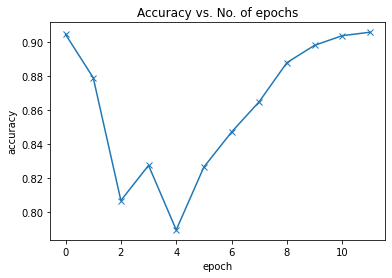

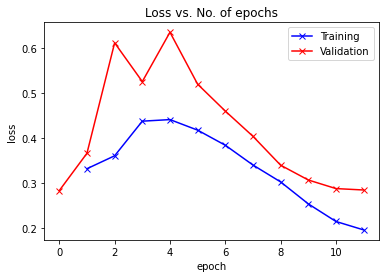

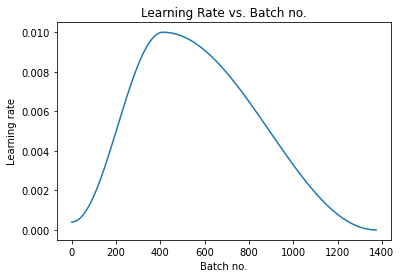

[{'val_loss': 0.2846361994743347, 'val_acc': 0.9058654308319092}]
[[{'val_loss': 0.2846361994743347, 'val_acc': 0.9058654308319092}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
[{'val_loss': 2.302971601486206, 'val_acc': 0.10009615123271942}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuning 1/1
Pruning...
Global Sparsity91.00001776072747%
[{'val_loss': 2.3

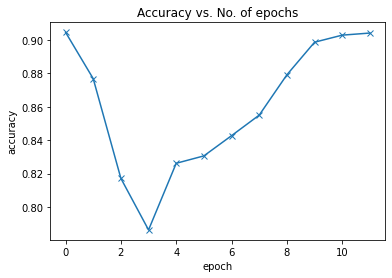

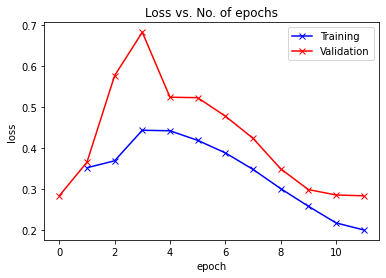

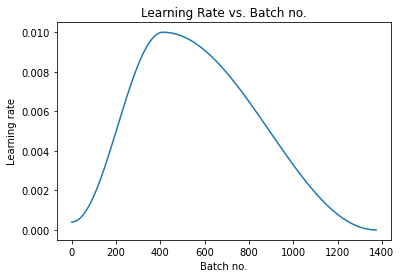

[{'val_loss': 0.28340059518814087, 'val_acc': 0.9041346907615662}]
[[{'val_loss': 0.2846361994743347, 'val_acc': 0.9058654308319092}], [{'val_loss': 0.28340059518814087, 'val_acc': 0.9041346907615662}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
[{'val_loss': 2.302838087081909, 'val_acc': 0.10009615123271942}]
[{'val_loss': 0.28327253460884094, 'val_acc': 0.9046154022216797}]
Pruning and Finetuni

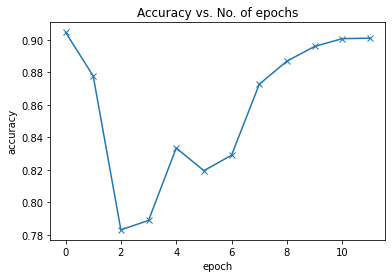

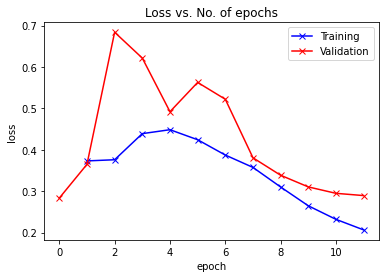

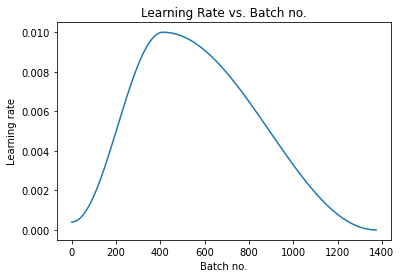

[{'val_loss': 0.2893209159374237, 'val_acc': 0.9009614586830139}]
[[{'val_loss': 0.2846361994743347, 'val_acc': 0.9058654308319092}], [{'val_loss': 0.28340059518814087, 'val_acc': 0.9041346907615662}], [{'val_loss': 0.2893209159374237, 'val_acc': 0.9009614586830139}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
[{'val_loss': 2.3029239177703857, 'val_acc': 0.09913460910320282}]
[{'val_loss': 0.2832

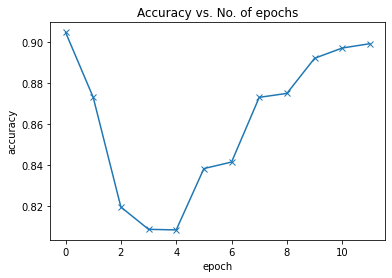

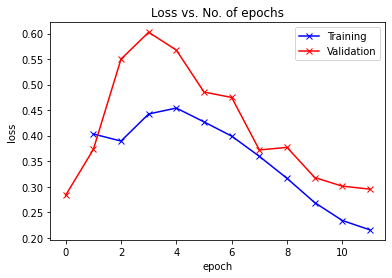

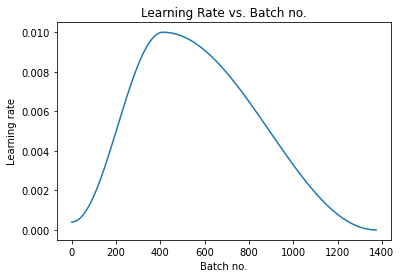

[{'val_loss': 0.2951986491680145, 'val_acc': 0.8990383744239807}]
[[{'val_loss': 0.2846361994743347, 'val_acc': 0.9058654308319092}], [{'val_loss': 0.28340059518814087, 'val_acc': 0.9041346907615662}], [{'val_loss': 0.2893209159374237, 'val_acc': 0.9009614586830139}], [{'val_loss': 0.2951986491680145, 'val_acc': 0.8990383744239807}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
[{'val_loss': 2.3029

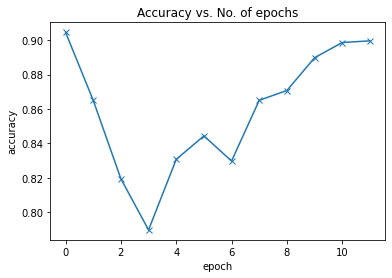

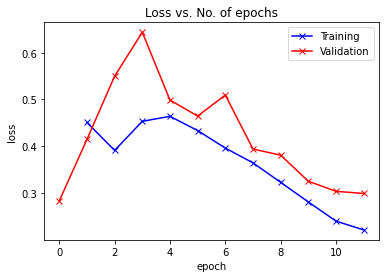

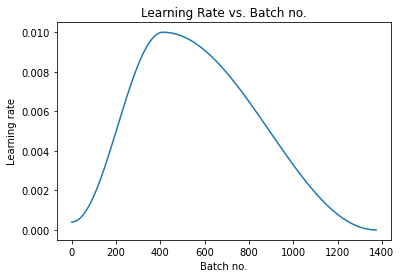

[{'val_loss': 0.29911184310913086, 'val_acc': 0.8996152877807617}]
[[{'val_loss': 0.2846361994743347, 'val_acc': 0.9058654308319092}], [{'val_loss': 0.28340059518814087, 'val_acc': 0.9041346907615662}], [{'val_loss': 0.2893209159374237, 'val_acc': 0.9009614586830139}], [{'val_loss': 0.2951986491680145, 'val_acc': 0.8990383744239807}], [{'val_loss': 0.29911184310913086, 'val_acc': 0.8996152877807617}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.

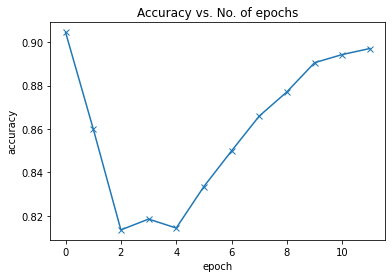

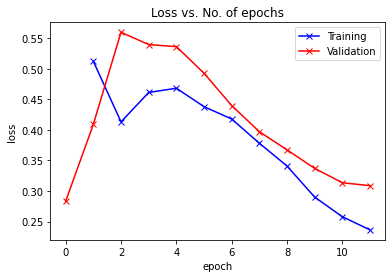

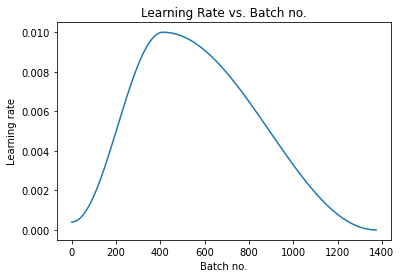

[{'val_loss': 0.30877503752708435, 'val_acc': 0.8971154093742371}]
[[{'val_loss': 0.2846361994743347, 'val_acc': 0.9058654308319092}], [{'val_loss': 0.28340059518814087, 'val_acc': 0.9041346907615662}], [{'val_loss': 0.2893209159374237, 'val_acc': 0.9009614586830139}], [{'val_loss': 0.2951986491680145, 'val_acc': 0.8990383744239807}], [{'val_loss': 0.29911184310913086, 'val_acc': 0.8996152877807617}], [{'val_loss': 0.30877503752708435, 'val_acc': 0.8971154093742371}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
       

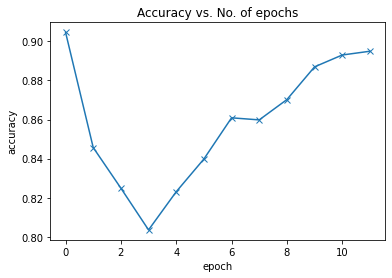

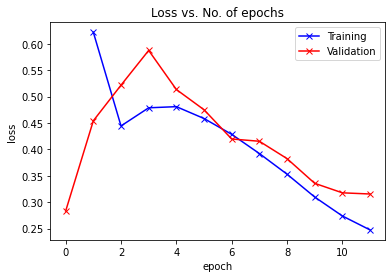

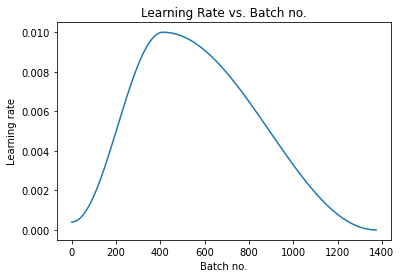

[{'val_loss': 0.3154922127723694, 'val_acc': 0.8949038982391357}]
[[{'val_loss': 0.2846361994743347, 'val_acc': 0.9058654308319092}], [{'val_loss': 0.28340059518814087, 'val_acc': 0.9041346907615662}], [{'val_loss': 0.2893209159374237, 'val_acc': 0.9009614586830139}], [{'val_loss': 0.2951986491680145, 'val_acc': 0.8990383744239807}], [{'val_loss': 0.29911184310913086, 'val_acc': 0.8996152877807617}], [{'val_loss': 0.30877503752708435, 'val_acc': 0.8971154093742371}], [{'val_loss': 0.3154922127723694, 'val_acc': 0.8949038982391357}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/

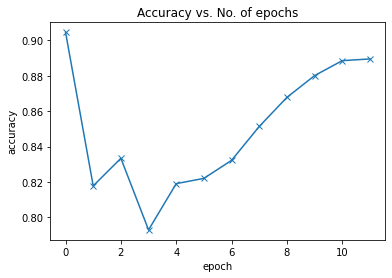

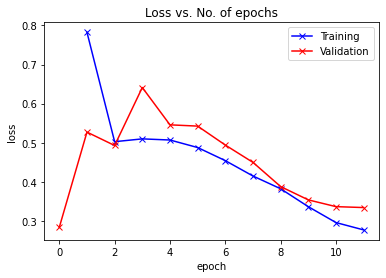

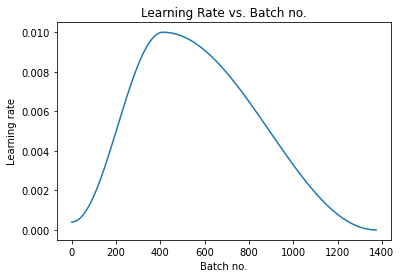

[{'val_loss': 0.33391329646110535, 'val_acc': 0.8895193338394165}]
[[{'val_loss': 0.2846361994743347, 'val_acc': 0.9058654308319092}], [{'val_loss': 0.28340059518814087, 'val_acc': 0.9041346907615662}], [{'val_loss': 0.2893209159374237, 'val_acc': 0.9009614586830139}], [{'val_loss': 0.2951986491680145, 'val_acc': 0.8990383744239807}], [{'val_loss': 0.29911184310913086, 'val_acc': 0.8996152877807617}], [{'val_loss': 0.30877503752708435, 'val_acc': 0.8971154093742371}], [{'val_loss': 0.3154922127723694, 'val_acc': 0.8949038982391357}], [{'val_loss': 0.33391329646110535, 'val_acc': 0.8895193338394165}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dat

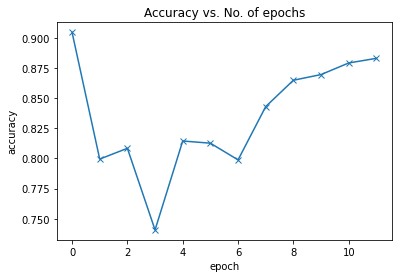

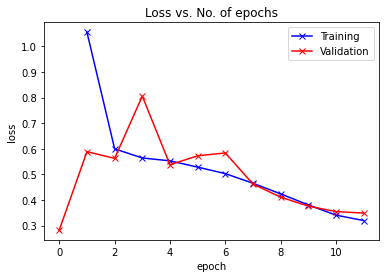

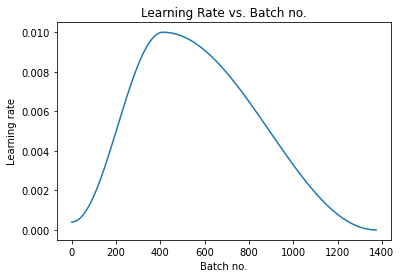

[{'val_loss': 0.349033921957016, 'val_acc': 0.8829808831214905}]
[[{'val_loss': 0.2846361994743347, 'val_acc': 0.9058654308319092}], [{'val_loss': 0.28340059518814087, 'val_acc': 0.9041346907615662}], [{'val_loss': 0.2893209159374237, 'val_acc': 0.9009614586830139}], [{'val_loss': 0.2951986491680145, 'val_acc': 0.8990383744239807}], [{'val_loss': 0.29911184310913086, 'val_acc': 0.8996152877807617}], [{'val_loss': 0.30877503752708435, 'val_acc': 0.8971154093742371}], [{'val_loss': 0.3154922127723694, 'val_acc': 0.8949038982391357}], [{'val_loss': 0.33391329646110535, 'val_acc': 0.8895193338394165}], [{'val_loss': 0.349033921957016, 'val_acc': 0.8829808831214905}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914

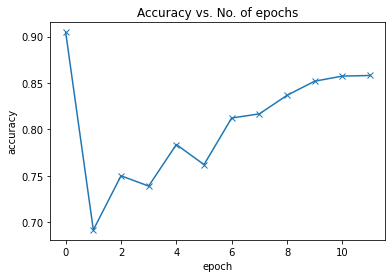

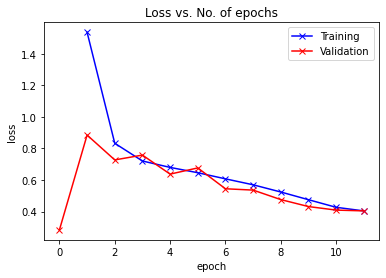

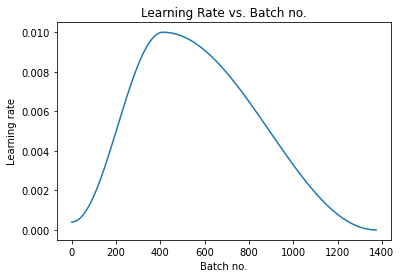

[{'val_loss': 0.4039755165576935, 'val_acc': 0.8580769896507263}]
[[{'val_loss': 0.2846361994743347, 'val_acc': 0.9058654308319092}], [{'val_loss': 0.28340059518814087, 'val_acc': 0.9041346907615662}], [{'val_loss': 0.2893209159374237, 'val_acc': 0.9009614586830139}], [{'val_loss': 0.2951986491680145, 'val_acc': 0.8990383744239807}], [{'val_loss': 0.29911184310913086, 'val_acc': 0.8996152877807617}], [{'val_loss': 0.30877503752708435, 'val_acc': 0.8971154093742371}], [{'val_loss': 0.3154922127723694, 'val_acc': 0.8949038982391357}], [{'val_loss': 0.33391329646110535, 'val_acc': 0.8895193338394165}], [{'val_loss': 0.349033921957016, 'val_acc': 0.8829808831214905}], [{'val_loss': 0.4039755165576935, 'val_acc': 0.8580769896507263}]]
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=

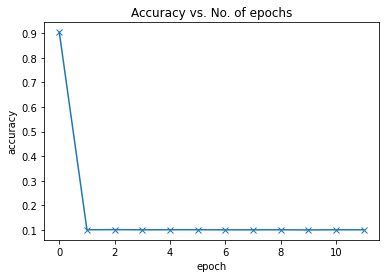

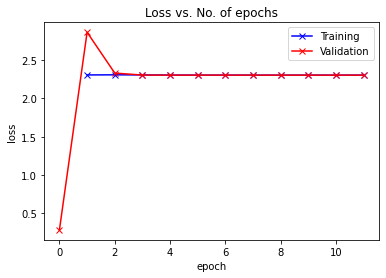

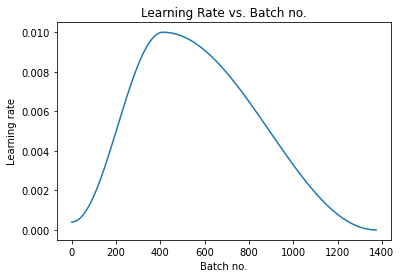

[{'val_loss': 2.3025963306427, 'val_acc': 0.10009615123271942}]
[[{'val_loss': 0.2846361994743347, 'val_acc': 0.9058654308319092}], [{'val_loss': 0.28340059518814087, 'val_acc': 0.9041346907615662}], [{'val_loss': 0.2893209159374237, 'val_acc': 0.9009614586830139}], [{'val_loss': 0.2951986491680145, 'val_acc': 0.8990383744239807}], [{'val_loss': 0.29911184310913086, 'val_acc': 0.8996152877807617}], [{'val_loss': 0.30877503752708435, 'val_acc': 0.8971154093742371}], [{'val_loss': 0.3154922127723694, 'val_acc': 0.8949038982391357}], [{'val_loss': 0.33391329646110535, 'val_acc': 0.8895193338394165}], [{'val_loss': 0.349033921957016, 'val_acc': 0.8829808831214905}], [{'val_loss': 0.4039755165576935, 'val_acc': 0.8580769896507263}], [{'val_loss': 2.3025963306427, 'val_acc': 0.10009615123271942}]]


In [ ]:
if __name__ == '__main__':
    # Data transforms (normalization & data augmentation)
    percent=[]
    #iteratively pruned loaded model 
    post_finetuning_history=[]
    post_pruning_history=[]
    for i in range(11):
      stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
      train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                              tt.RandomHorizontalFlip(), 
                              # tt.RandomRotate
                              # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                              # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                              tt.ToTensor(), 
                              tt.Normalize(*stats,inplace=True)])
      valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
      # PyTorch datasets
      train_ds = CIFAR10(root='data/', download=True, transform=train_tfms)
      valid_ds = CIFAR10(root='data/', train=False, transform=valid_tfms)
      dataset_size = len(train_ds)
      test_dataset_size = len(valid_ds)
      print(train_ds)
      print(valid_ds)
      batch_size = 400

      # PyTorch data loaders
      train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
      valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)
      device = get_default_device()
      # device = torch.device('cpu')
      train_dl = DeviceDataLoader(train_dl, device)
      valid_dl = DeviceDataLoader(valid_dl, device)

      model = to_device(Cifar10CnnModel(), device)
      # print(model)
      os.environ['WANDB_CONSOLE'] = 'off'
      history = [evaluate(model, valid_dl)]
      print(history)

      epochs = 11
      max_lr = 0.01
      grad_clip = 0.1
      weight_decay = 1e-4
      opt_func = torch.optim.Adam
      
      os.environ['WANDB_CONSOLE'] = 'off'
      model = to_device(Cifar10CnnModel(), device)
      percent.append((i+90))
      model.load_state_dict(torch.load('/content/drive/MyDrive/VCL/VCL/T1/M1_epoch_10.pt'))
      # model.load_state_dict(torch.load('/content/drive/MyDrive/VCL/T1/M1_epoch_10.pt',map_location=torch.device('cpu')))
      history_final , post_pruning=iterative_pruning_finetuning(epochs, max_lr, model, train_dl, valid_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func,input=i)
      post_finetuning_history.append(history_final)
      post_pruning_history.append(post_pruning)
      print(post_finetuning_history)
    
    

In [ ]:
def post_finetuning_history_plot(history):
    x_axis=[]
    for x in  history:
      for y in x:
        x_axis.append(y['val_acc'])
    
    
    plt.scatter(percent,x_axis)
    plt.xlabel('%pruning')
    plt.ylabel('val_acc')
    plt.title('post_finetuning_accuracy')
    plt.savefig(f'/content/drive/MyDrive/VCL/T3/post_finetuning_accuracy.pdf',format='pdf')
    plt.show()

def post_pruning_history_plot(history):
    x_axis=[]
    for x in  history:
      for y in x:
        x_axis.append(y['val_acc'])
    
    
    plt.scatter(percent,x_axis)
    plt.xlabel('%pruning')
    plt.ylabel('val_acc')
    plt.title('post_pruning_accuracy')
    plt.savefig(f'/content/drive/MyDrive/VCL/T3/post_pruning_accuracy.pdf',format='pdf')
    plt.show()

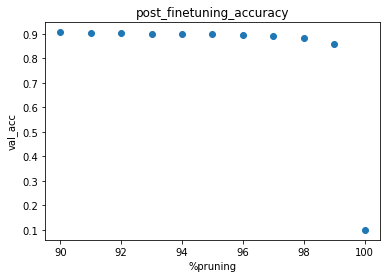

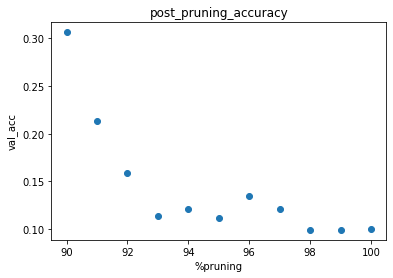

In [ ]:
post_finetuning_history_plot(post_finetuning_history)
post_pruning_history_plot(post_pruning_history)

In [ ]:
pruning=[[{'val_loss': 0.2846361994743347, 'val_acc': 0.9058654308319092}], [{'val_loss': 0.28340059518814087, 'val_acc': 0.9041346907615662}], [{'val_loss': 0.2893209159374237, 'val_acc': 0.9009614586830139}], [{'val_loss': 0.2951986491680145, 'val_acc': 0.8990383744239807}], [{'val_loss': 0.29911184310913086, 'val_acc': 0.8996152877807617}], [{'val_loss': 0.30877503752708435, 'val_acc': 0.8971154093742371}], [{'val_loss': 0.3154922127723694, 'val_acc': 0.8949038982391357}], [{'val_loss': 0.33391329646110535, 'val_acc': 0.8895193338394165}], [{'val_loss': 0.349033921957016, 'val_acc': 0.8829808831214905}], [{'val_loss': 0.4039755165576935, 'val_acc': 0.8580769896507263}]]


In [ ]:
pruning

[[{'val_loss': 0.2846361994743347, 'val_acc': 0.9058654308319092}],
 [{'val_loss': 0.28340059518814087, 'val_acc': 0.9041346907615662}],
 [{'val_loss': 0.2893209159374237, 'val_acc': 0.9009614586830139}],
 [{'val_loss': 0.2951986491680145, 'val_acc': 0.8990383744239807}],
 [{'val_loss': 0.29911184310913086, 'val_acc': 0.8996152877807617}],
 [{'val_loss': 0.30877503752708435, 'val_acc': 0.8971154093742371}],
 [{'val_loss': 0.3154922127723694, 'val_acc': 0.8949038982391357}],
 [{'val_loss': 0.33391329646110535, 'val_acc': 0.8895193338394165}],
 [{'val_loss': 0.349033921957016, 'val_acc': 0.8829808831214905}],
 [{'val_loss': 0.4039755165576935, 'val_acc': 0.8580769896507263}]]

In [ ]:
freezing=[[{'val_loss': 0.28396177291870117, 'val_acc': 0.9057692885398865}], [{'val_loss': 0.2869068384170532, 'val_acc': 0.9058653712272644}], [{'val_loss': 0.2854851186275482, 'val_acc': 0.9041346311569214}], [{'val_loss': 0.29676371812820435, 'val_acc': 0.9004808664321899}], [{'val_loss': 0.3007102608680725, 'val_acc': 0.8993269205093384}], [{'val_loss': 0.30411598086357117, 'val_acc': 0.8982692360877991}], [{'val_loss': 0.30925968289375305, 'val_acc': 0.8967307806015015}], [{'val_loss': 0.32866016030311584, 'val_acc': 0.8873077034950256}], [{'val_loss': 0.35083937644958496, 'val_acc': 0.8829807639122009}], [{'val_loss': 0.40066125988960266, 'val_acc': 0.861057698726654}]]

In [ ]:
freezing

[[{'val_loss': 0.28396177291870117, 'val_acc': 0.9057692885398865}],
 [{'val_loss': 0.2869068384170532, 'val_acc': 0.9058653712272644}],
 [{'val_loss': 0.2854851186275482, 'val_acc': 0.9041346311569214}],
 [{'val_loss': 0.29676371812820435, 'val_acc': 0.9004808664321899}],
 [{'val_loss': 0.3007102608680725, 'val_acc': 0.8993269205093384}],
 [{'val_loss': 0.30411598086357117, 'val_acc': 0.8982692360877991}],
 [{'val_loss': 0.30925968289375305, 'val_acc': 0.8967307806015015}],
 [{'val_loss': 0.32866016030311584, 'val_acc': 0.8873077034950256}],
 [{'val_loss': 0.35083937644958496, 'val_acc': 0.8829807639122009}],
 [{'val_loss': 0.40066125988960266, 'val_acc': 0.861057698726654}]]

In [ ]:
def plot_pruningVSfreezing_history(history_pruning,history_freezing):
    a_axis=[]
    for x in  history_pruning:
      for y in x:
        a_axis.append(y['val_acc'])
    b_axis=[]
    for x in  history_freezing:
      for y in x:
        b_axis.append(y['val_acc'])
    plt.plot(percent[:-1],a_axis, '-bx')
    plt.plot(percent[:-1],b_axis, '-rx')
    plt.xlabel('percent_pruning')
    plt.ylabel('acuuracy')
    plt.legend(['pruning', 'freezing'])
    plt.title('pruning vs freezing')
    # plt.savefig(f'/content/drive/MyDrive/VCL/T3/Loss_vs._No. of epochs_{(float(input)/100+.9)*100}%pruned.pdf',format='pdf')
    plt.show()

In [ ]:
percent

[90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

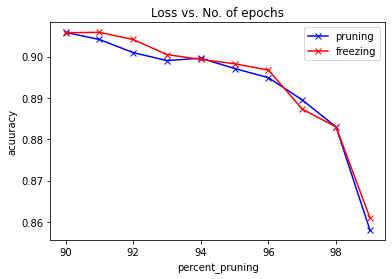

In [ ]:
plot_pruningVSfreezing_history(a,b)